## Vizualize methylation profile of T.NPSG and T. erythraeum using output from MicrobeMod v1.0.4(https://github.com/cultivarium/MicrobeMod)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import matplotlib
import pypalettes
from pypalettes import load_cmap
from pypalettes import get_hex
from pycirclize import Circos
from pycirclize.parser import Gff, Genbank
from pycirclize.utils import load_prokaryote_example_file, ColorCycler
from matplotlib.patches import Patch
from matplotlib.patches import Circle
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from scipy import stats

In [2]:
#read in MicrobeMod output
methylated_sites = pd.read_csv('methylation_files/tricho_phage_npsg_2_methylated_sites.tsv',sep='\t',index_col=0)
motifs = pd.read_csv('methylation_files/tricho_phage_npsg_2_motifs.tsv',sep='\t',index_col=0)

## Circos plot depicting modified sites in phage genome

In [3]:
#make color map for modification types/percent modified

cmap = load_cmap("sPBIRd").hex
mod_6ma_colors = {0.67:cmap[2],0.71:cmap[3],0.75:cmap[4],0.8:cmap[5],0.83:cmap[6],0.86:cmap[7],1:cmap[8]}
cmap2 = load_cmap("sPBIYl").hex
mod_5mc_colors = {0.67:cmap2[2],0.71:cmap2[3],0.75:cmap2[4],0.8:cmap2[5],0.83:cmap2[6],0.86:cmap2[7],1:cmap2[8]}

hex_colors = load_cmap("golduck").hex
function_palette = {'tail':hex_colors[5], 'head and packaging':hex_colors[8],
                    'DNA, RNA and nucleotide metabolism':hex_colors[0],'integration and excision':hex_colors[1],'transcription regulation':hex_colors[2],'RM system':hex_colors[3], 'Phage defense':'#d0eafb',
                   'auxiliary metabolism, host takeover':hex_colors[9],'Host range determination':hex_colors[12],'lysis':hex_colors[11],
                    'unknown function':'#cccccc', 'conserved protein of unknown function':'#000000'}

In [4]:
#get depth of long read mapping to phage genome - need coverage > 3x to call mods
ont_depth = pd.read_csv('methylation_files/slick_phage_ont.cov',sep='\t',header=None,names=['genome','site','depth'])
ont_depth.loc[:,'mean_50'] = ont_depth['depth'].rolling(500).mean().fillna(0)
smoothed_depth = ont_depth['depth'].rolling(500,step=50).mean().fillna(0)

In [5]:
#Get genome regions where long read coverage < 3, ie where we can't call mods
low_cov = [] #list of tuples indicating where we need to indicate that coverage is too low to call mods
below_3 = False
start = 0
end = 0
prev_index = 0
for i in smoothed_depth.index.values:
    if not below_3:
        if smoothed_depth.loc[i] > 3:
            pass
        else: #If we aren't currently in a below 3 range but the next value is, need to start new tuple
            start = i
            below_3 = True
    if below_3:
        if smoothed_depth.loc[i] > 3:#if we are currently in a below 3 range but the next value is above it, need to end range
            end = prev_index
            low_cov.append((start,end))
            below_3 = False
        else: #if we are currently in a below 3 range and the next value is as well, keep going
            pass
    prev_index = i
if below_3:
    low_cov.append((start,prev_index))

In [6]:
gbk = Genbank('annotation_files/tricho_phage_NPSG_2.gbk')

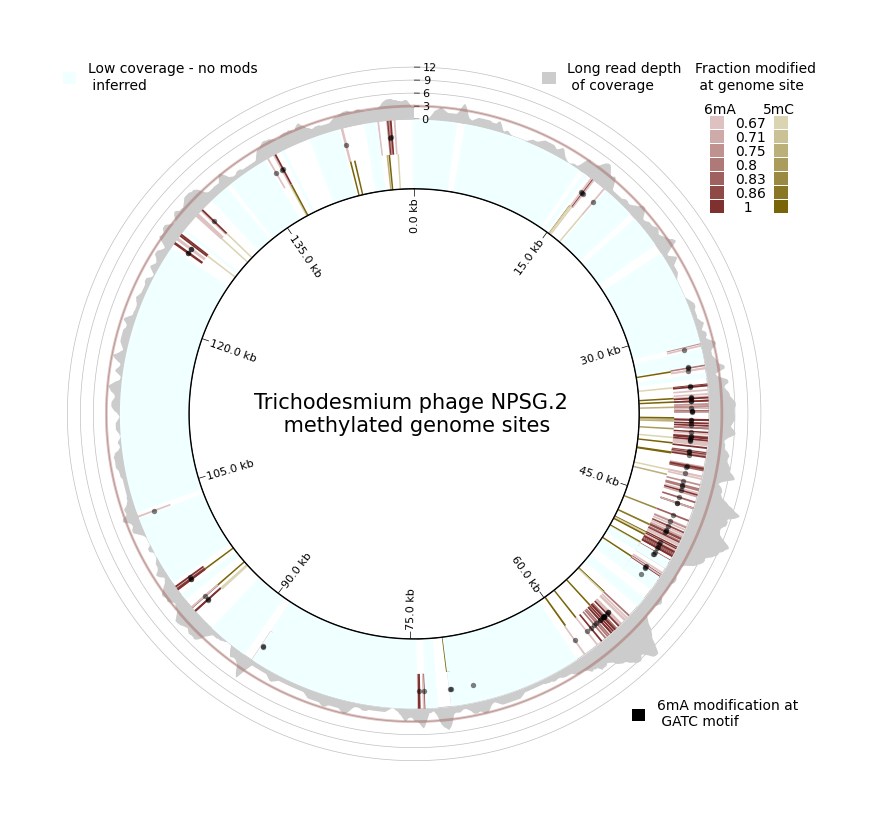

In [7]:
seqid2size = gbk.get_seqid2size()
space = 0 if len(seqid2size) == 1 else 2
circos = Circos(sectors=seqid2size, space=space)
circos.text("Trichodesmium phage NPSG.2 \n methylated genome sites", size=15)
seqid2features = gbk.get_seqid2features(feature_type="CDS")
seqid2seq = gbk.get_seqid2seq()

for sector in circos.sectors:
    depth_track = sector.add_track((85,100))
    depth_track.grid(y_grid_num=5)
    depth_track.fill_between(smoothed_depth.index.values,(smoothed_depth.values),0,color='#cccccc',vmin=0,vmax=12)
    depth_track.line(smoothed_depth.index.values,[3]*len(smoothed_depth.index.values),color='#7E0C01FF',vmin=0,vmax=12,alpha=0.25,lw=2)
    depth_track.yticks([0,3,6,9,12],['0','3','6','9','12'],vmin=0,vmax=12)
    mod_track_1 = sector.add_track((75,85))
    mod_track_2 = sector.add_track((65,75))
    
    #loop over results from MicrobeMod, plotting modifications colored by type
    for index,row in methylated_sites.iterrows():
        position = row['Position']
        mod = row['Modification']
        percent = row['Percent_modified']
        if mod == '6mA':
            mod_track_1.rect(position-75,position+75,color=mod_6ma_colors[percent])
        else:
            mod_track_2.rect(position-75,position+75,color=mod_5mc_colors[percent])

    #star 6mA sites at conserved GATC motif
    mod_track_1.scatter(methylated_sites[~methylated_sites['motif'].isna()]['Position'].values,
                        [.5]*len(methylated_sites[~methylated_sites['motif'].isna()]['Position'].values),marker='o',vmax=1,color='black',
                       alpha=0.5,s=15)

    #Add gray-out for sites with coverage too low to call mods

    for range1 in low_cov:
        mod_track_1.rect(range1[0],range1[1],color='azure')
        mod_track_2.rect(range1[0],range1[1],color='azure')

    tick_track = sector.add_track((64.8,65))
    tick_track.axis(fc="black")
    tick_track.xticks_by_interval(15000,outer=False,label_formatter=lambda v: f"{v/1000:.1f} kb",label_orientation="vertical")


fig = circos.plotfig()

first_legend = circos.ax.legend(handles=[Patch(color='#cccccc',label='Long read depth \n of coverage')],fontsize=10, loc="upper right",bbox_to_anchor=(0.89,1))
circos.ax.add_artist(first_legend)

mod_6mA_handles = []
for i in mod_6ma_colors.keys():
    if i ==1:
        mod_6mA_handles.append(Patch(color=mod_6ma_colors[i], label='  1 '))
    else:
        mod_6mA_handles.append(Patch(color=mod_6ma_colors[i], label=str(i)))
second_legend = circos.ax.legend(handles=mod_6mA_handles,title='6mA',labelspacing = 0, loc="upper right",bbox_to_anchor=(1,0.945),fontsize=10)
second_legend.get_title().set_position((-18, 0))

mod_5mC_handles = []
for i in mod_5mc_colors.keys():
    if i ==1:
        mod_5mC_handles.append(Patch(color=mod_5mc_colors[i], label=''))
    else:
        mod_5mC_handles.append(Patch(color=mod_5mc_colors[i], label=''))
third_legend = circos.ax.legend(handles=mod_5mC_handles,title='5mC',labelspacing = 0, loc="upper right",bbox_to_anchor=(1.05,0.945),fontsize=10)
third_legend.get_title().set_position((-7, 0))
circos.ax.add_artist(second_legend)
circos.ax.add_artist(third_legend)

fourth_legend = circos.ax.legend(handles=[Patch(color='black',label='6mA modification at \n GATC motif')], loc="lower right",bbox_to_anchor=(1.05,0.05),fontsize=10)
circos.ax.add_artist(fourth_legend)
fifth_length = circos.ax.legend(handles=[Patch(color='azure',label='Low coverage - no mods \n inferred')],fontsize=10, loc="upper left",bbox_to_anchor=(0,1))

plt.text(.885,.9455,'Fraction modified \n at genome site',transform = circos.ax.transAxes,fontsize=10)
#fig.savefig('output_files/fig3a_mod_phage.svg',bbox_inches='tight')

In [8]:
#read in MicrobeMod output for tricho genomes
methylated_sites = pd.read_csv('methylation_files/tery_IMS101_ref_methylated_sites.tsv',sep='\t',index_col=0)
motifs = pd.read_csv('methylation_files/tery_IMS101_ref_motifs.tsv',sep='\t',index_col=0)

In [10]:
#get depth of long read mapping to phage genome - need coverage > 3x to call mods
ont_depth = pd.read_csv('methylation_files/tery_mods_ref_ont.cov',sep='\t',header=None,names=['genome','site','depth'])
ont_depth.loc[:,'mean_50'] = ont_depth['depth'].rolling(500).mean().fillna(0)
smoothed_depth = ont_depth['depth'].rolling(500,step=50).mean().fillna(0)
cut_smoothed_depth = smoothed_depth.where(smoothed_depth <=20, 20)

In [11]:
#Get genome regions where long read coverage < 3, ie where we can't call mods
low_cov = [] #list of tuples indicating where we need to indicate that coverage is too low to call mods
below_3 = False
start = 0
end = 0
prev_index = 0
for i in cut_smoothed_depth.index.values:
    if not below_3:
        if cut_smoothed_depth.loc[i] > 3:
            pass
        else: #If we aren't currently in a below 3 range but the next value is, need to start new tuple
            start = i
            below_3 = True
    if below_3:
        if cut_smoothed_depth.loc[i] > 3:#if we are currently in a below 3 range but the next value is above it, need to end range
            end = prev_index
            low_cov.append((start,end))
            below_3 = False
        else: #if we are currently in a below 3 range and the next value is as well, keep going
            pass
    prev_index = i
if below_3:
    low_cov.append((start,prev_index))

In [12]:
mod_6ma_colors = {0.67: '#DEC2C1FF',
 0.71: '#CEAAA8FF',
 0.73: '#CEAAA8FF',
 0.75: '#BF9290FF',
 0.78: '#BF9290FF',
 0.8: '#AF7978FF',
 0.83: '#AF7978FF',
 0.86: '#9F6160FF',
 0.88: '#9F6160FF',
 0.9: '#8F4947FF',
 0.92: '#8F4947FF',
 1: '#7F312FFF'}
mod_5mc_colors = {0.67: '#DBD4B2FF',
 0.71: '#CBC196FF',
 0.73: '#CBC196FF',
 0.75: '#BBAF7AFF',
 0.78: '#BBAF7AFF',
 0.8: '#AA9C5DFF',
 0.83: '#AA9C5DFF',
 0.86: '#9A8941FF',
 0.88: '#9A8941FF',
 0.9: '#897725FF',
 0.92: '#897725FF',
 1: '#796409FF'}

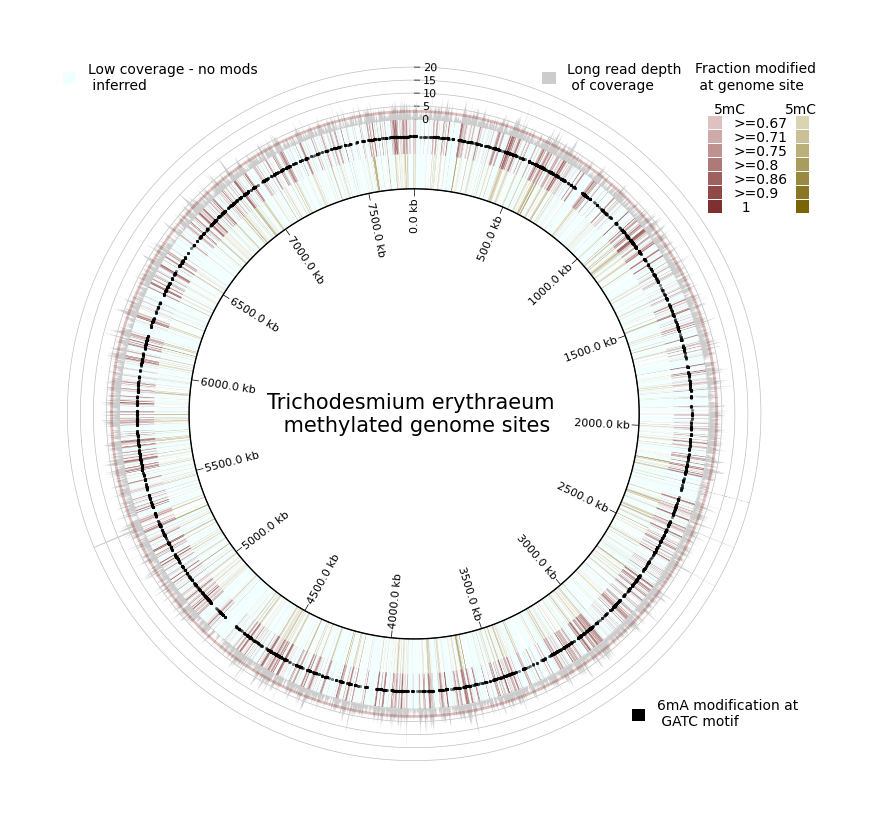

In [14]:
gbk = Genbank('methylation_files/tery_IMS101_ref.gbk')
seqid2size = gbk.get_seqid2size()
space = 0 if len(seqid2size) == 1 else 2
circos = Circos(sectors=seqid2size, space=space)
circos.text("Trichodesmium erythraeum \n methylated genome sites", size=15)
seqid2features = gbk.get_seqid2features(feature_type="CDS")
seqid2seq = gbk.get_seqid2seq()
for sector in circos.sectors:
    depth_track = sector.add_track((85,100))
    depth_track.grid(y_grid_num=5)
    depth_track.fill_between(cut_smoothed_depth.index.values,(cut_smoothed_depth.values),0,color='#cccccc',vmin=0,vmax=20)
    depth_track.line(cut_smoothed_depth.index.values,[3]*len(cut_smoothed_depth.index.values),color='#7E0C01FF',vmin=0,vmax=20,alpha=0.25,lw=2)
    depth_track.yticks([0,5,10,15,20],['0','5','10','15','20'],vmin=0,vmax=20)
    mod_track_1 = sector.add_track((75,85))
    mod_track_2 = sector.add_track((65,75))
    
    #loop over results from MicrobeMod, plotting modifications colored by type
    for index,row in methylated_sites.iterrows():
        position = row['Position']
        mod = row['Modification']
        percent = row['Percent_modified']
        if mod == '6mA':
            mod_track_1.rect(position-250,position+250,color=mod_6ma_colors[percent])
        else:
            mod_track_2.rect(position-250,position+250,color=mod_5mc_colors[percent])

    #star 6mA sites at conserved GATC motif
    mod_track_1.scatter(methylated_sites[~methylated_sites['motif'].isna()]['Position'].values,
                        [.5]*len(methylated_sites[~methylated_sites['motif'].isna()]['Position'].values),marker='o',vmax=1,color='black',
                       alpha=0.5,s=5)
    
    for range1 in low_cov:
        mod_track_1.rect(range1[0],range1[1],color='azure')
        mod_track_2.rect(range1[0],range1[1],color='azure')
        
    tick_track = sector.add_track((64.8,65))
    tick_track.axis(fc="black")
    tick_track.xticks_by_interval(500000,outer=False,label_formatter=lambda v: f"{v/1000:.1f} kb",label_orientation="vertical")


fig = circos.plotfig()

first_legend = circos.ax.legend(handles=[Patch(color='#cccccc',label='Long read depth \n of coverage')],fontsize=10, loc="upper right",bbox_to_anchor=(0.89,1))
circos.ax.add_artist(first_legend)

mod_6mA_handles = []
for i in mod_6ma_colors.keys():
    if i ==1:
        mod_6mA_handles.append(Patch(color=mod_6ma_colors[i], label='  1 '))
    elif i in [.73,.78,.83,.88,.92]:
        pass
    else:
        mod_6mA_handles.append(Patch(color=mod_6ma_colors[i], label='>='+str(i)))
second_legend = circos.ax.legend(handles=mod_6mA_handles,title='5mC',labelspacing = 0, loc="upper right",bbox_to_anchor=(1.03,0.945),fontsize=10)
second_legend.get_title().set_position((-18, 0))

mod_5mC_handles = []
for i in mod_5mc_colors.keys():
    if i ==1:
        mod_5mC_handles.append(Patch(color=mod_5mc_colors[i], label=''))
    elif i in [.73,.78,.83,.88,.92]:
        pass
    else:
        mod_5mC_handles.append(Patch(color=mod_5mc_colors[i], label=''))
third_legend = circos.ax.legend(handles=mod_5mC_handles,title='5mC',labelspacing = 0, loc="upper right",bbox_to_anchor=(1.08,0.945),fontsize=10)
third_legend.get_title().set_position((-7, 0))
circos.ax.add_artist(second_legend)
circos.ax.add_artist(third_legend)

fourth_legend = circos.ax.legend(handles=[Patch(color='black',label='6mA modification at \n GATC motif')], loc="lower right",bbox_to_anchor=(1.05,0.05),fontsize=10)
circos.ax.add_artist(fourth_legend)
fifth_length = circos.ax.legend(handles=[Patch(color='azure',label='Low coverage - no mods \n inferred')],fontsize=10, loc="upper left",bbox_to_anchor=(0,1))

plt.text(.885,.9455,'Fraction modified \n at genome site',transform = circos.ax.transAxes,fontsize=10)
#fig.savefig('output_files/supp_fig_mod_tery.pdf',bbox_inches='tight')

## Differential expression of virus and host RM systems between picked colonies and slick

In [13]:
tery_tpm = pd.read_csv('metaT_files/tery_tpm.csv',index_col=0)
phage_tpm = pd.read_csv('metaT_files/phage_tpm.csv',index_col=0)
tery = tery_tpm.index.values

In [14]:
#read in MicrobeMod RM annotations for phage (v) and tricho 
slickv_rm = pd.read_csv('methylation_files/slick_phage_rm.rm.genes.tsv',sep='\t').drop([3])
slickv_rm = slickv_rm.set_index('Gene')

slick_rm = pd.read_csv('methylation_files/slick_tricho_rm.rm.genes.tsv',sep='\t')
slick_rm.loc[:,'contig'] = slick_rm['Gene'].str.rsplit('_',n=1,expand=True)[0]
#Get t.erythraeum specific RM annotations
tricho_rm = slick_rm[slick_rm['Gene'].isin(tery)].set_index('Gene')

In [15]:
tricho_rm.loc[:,'source'] = 'tery'
slickv_rm.loc[:,'source'] = 'phage'

In [16]:
#Combine phage and tricho RM annotations into one DF
all_rm = pd.concat([tricho_rm,slickv_rm])
#Update methylation type annotations based on manual annotation of T.NPSG genome
all_rm.loc['SHDOJQCQ_CDS_0158','Predicted methylation'] = 'm6A'
all_rm.loc['SHDOJQCQ_CDS_0161','Predicted methylation'] = 'm6A'

In [17]:
#Combine phage and tricho tpms into one DF
comb_tpm = pd.concat([tery_tpm,phage_tpm])
comb_tpm = comb_tpm + .05 #Can't have zeroes in heatmap

In [18]:
#pd.merge(all_rm,comb_tpm,left_index=True,right_index=True,how='left').to_csv('output_tables/supp_table_RM_tpm.csv')

In [9]:
all_rm.loc[:,'genelabel'] = all_rm['Gene type'].map({'RE':'#8F5715FF','MT':'#585B33FF','SP':'#B4B87FFF'})
all_rm.loc[:,'sitelabel'] = all_rm['Predicted methylation'].map({'m6A':'#9F615F','m5C':'#897725','cuts m5C':'#DBD4B2'})
all_rm.loc[:,'genomelabel'] = all_rm['source'].map({'tery':'#535260FF','phage':'#B7A7A6FF'})

<>:4: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\i'
/var/tmp/ipykernel_9006/2414694556.py:4: SyntaxWarning: invalid escape sequence '\i'
  genome_dict = {'$\it{T. erythraeum}$':'#535260FF','phage':'#B7A7A6FF'}


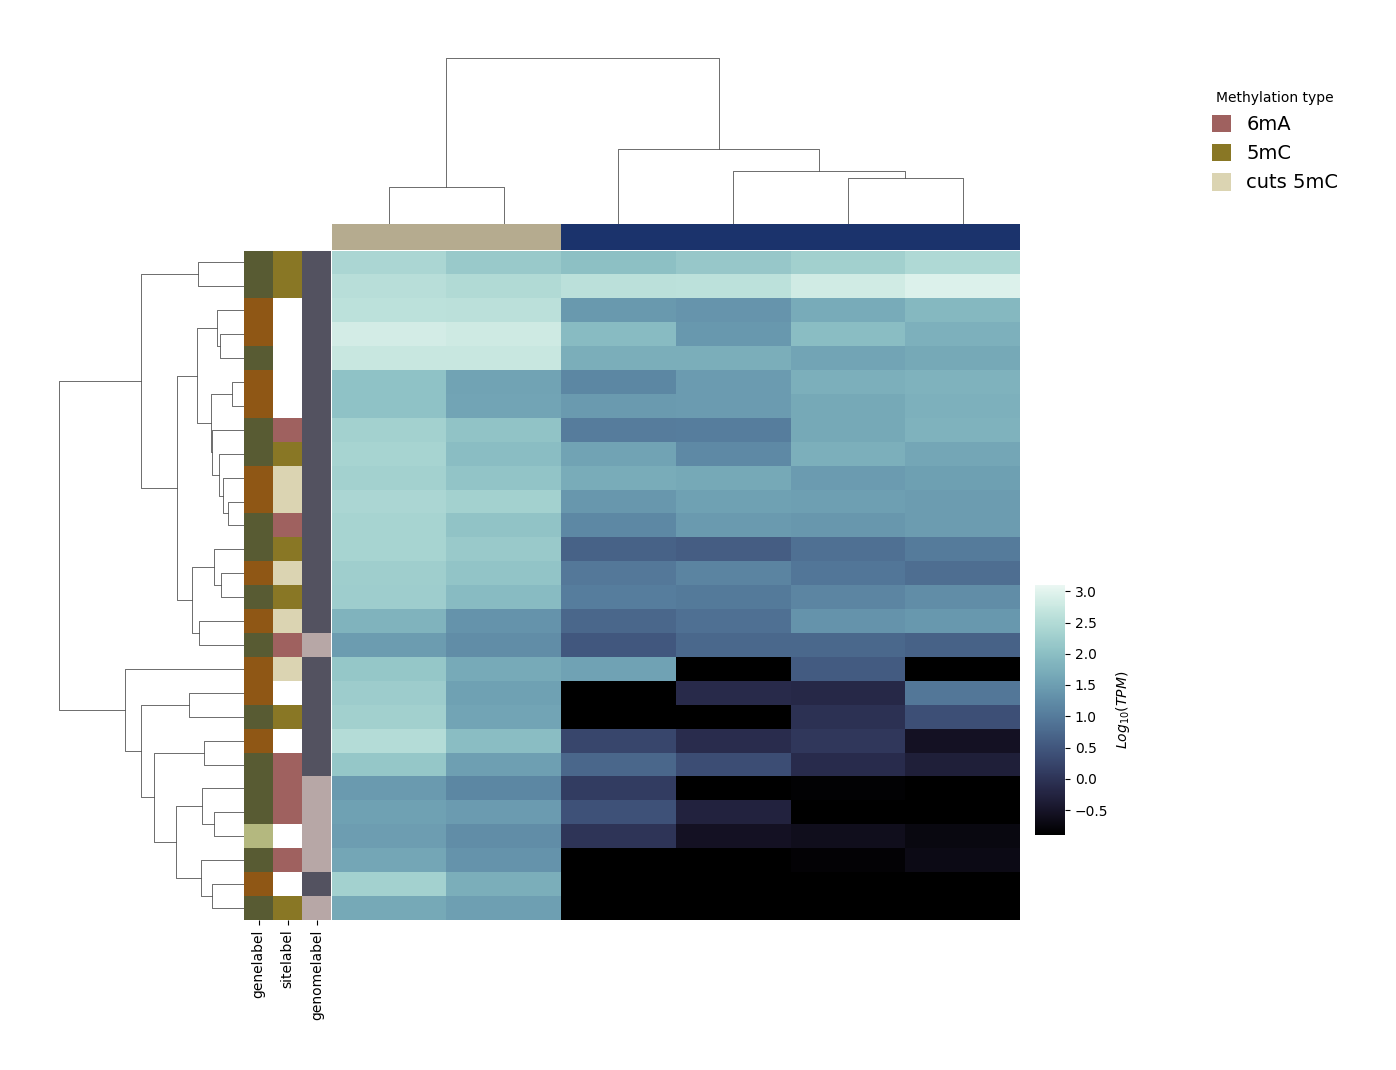

In [10]:
g=sns.clustermap(comb_tpm.apply(np.log10).loc[all_rm.index.values].astype(float),robust=True,yticklabels=False,xticklabels=False,col_colors=['#B5AB8F','#1B336C','#1B336C','#B5AB8F','#1B336C','#1B336C'],row_colors = all_rm[['genelabel','sitelabel','genomelabel']],cmap=sns.cubehelix_palette(start=.1, rot=-.3, dark=0, light=.95, reverse=True, as_cmap=True),
                cbar_pos=(1, 0.2, 0.03, 0.25),vmin=-.9,vmax=3.1,cbar_kws={'label': '$Log_{10}(TPM)$'})
handles1 = []
genome_dict = {'$\it{T. erythraeum}$':'#535260FF','phage':'#B7A7A6FF'}
for i in genome_dict.keys():
    handles1.append(Patch(color=genome_dict[i],label=i))

handles2 = []
meth_dict = {'6mA':'#9F615F','5mC':'#897725','cuts 5mC':'#DBD4B2'}
for i in meth_dict.keys():
    handles2.append(Patch(color=meth_dict[i],label=i))

handles3 = []
gene_dict = {'Restriction enzyme':'#8F5715FF','Methyltransferase':'#585B33FF','Specificity factor':'#B4B87FFF'}
for i in gene_dict.keys():
    handles3.append(Patch(color=gene_dict[i],label=i))

#plt.legend(handles=handles1, bbox_to_anchor=(6,2.5),loc='lower center', fontsize=14,title='Genome')
plt.legend(handles=handles2, bbox_to_anchor=(8,2.5),loc='lower center', fontsize=14,title='Methylation type')
#plt.legend(handles=handles3, bbox_to_anchor=(10,2.5),loc='lower center', fontsize=14,title='Enzyme type')
#plt.savefig('output_figures/fig3b_mod_heatmap_meth.svg',transparent=True,bbox_inches='tight')

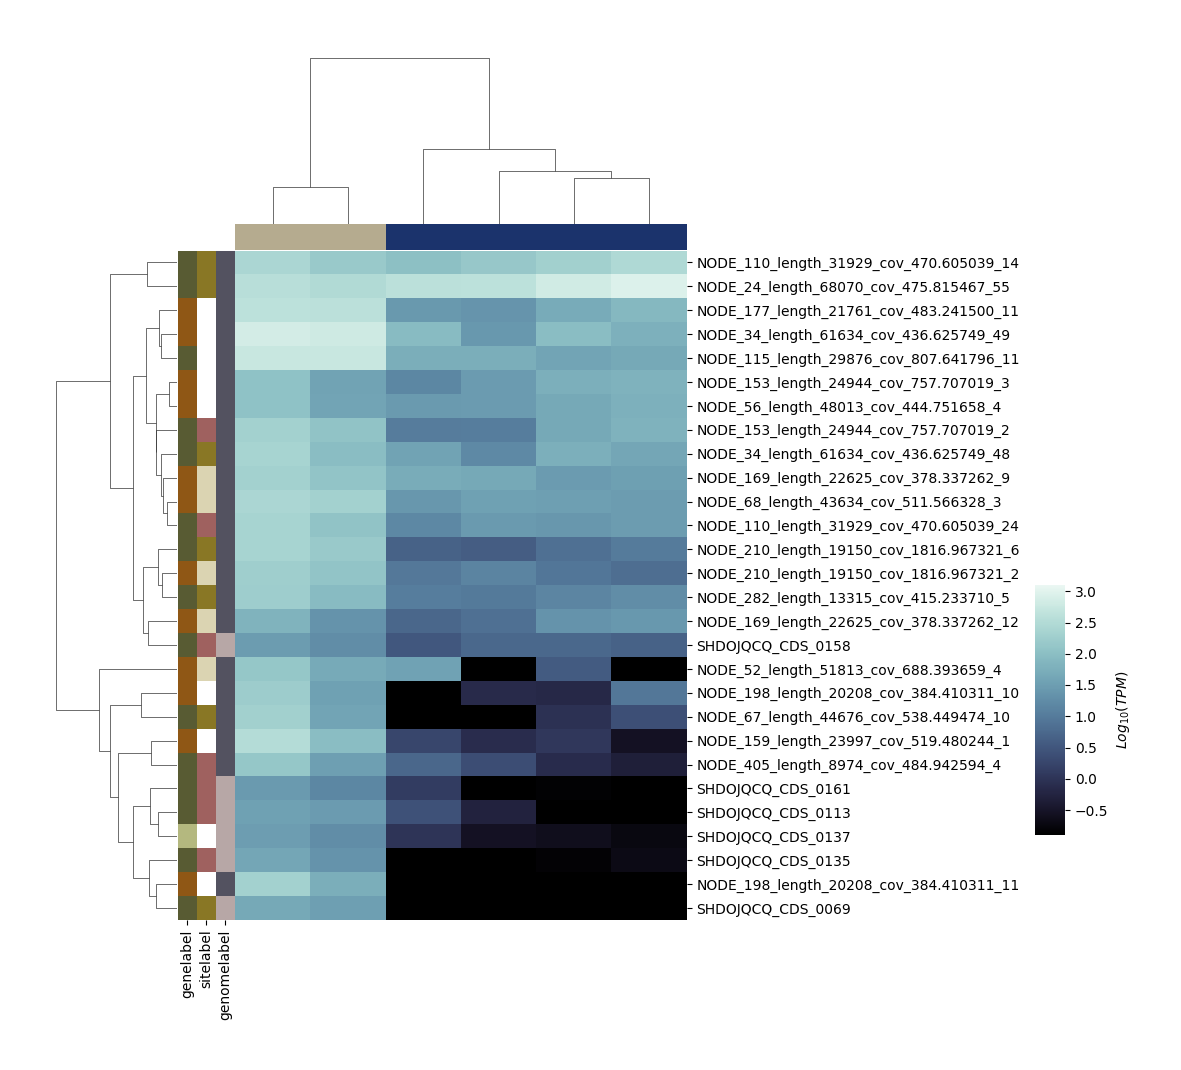

In [11]:
g=sns.clustermap(comb_tpm.apply(np.log10).loc[all_rm.index.values].astype(float),robust=True,xticklabels=False,col_colors=['#B5AB8F','#1B336C','#1B336C','#B5AB8F','#1B336C','#1B336C'],row_colors = all_rm[['genelabel','sitelabel','genomelabel']],cmap=sns.cubehelix_palette(start=.1, rot=-.3, dark=0, light=.95, reverse=True, as_cmap=True),
                cbar_pos=(1, 0.2, 0.03, 0.25),vmin=-.9,vmax=3.1,cbar_kws={'label': '$Log_{10}(TPM)$'})
#Get genes in each cluster
cluster_items = g.ax_heatmap.yaxis.get_majorticklabels()
labels_i = []
for i in cluster_items[0:2]:
    labels_i.append(i.get_text())
labels_ii = []
for i in cluster_items[2:17]:
    labels_ii.append(i.get_text())
labels_iii = []
for i in cluster_items[17:29]:
    labels_iii.append(i.get_text())

In [14]:
#Get slick vs. colonies KS test p value for each cluster (I,II,III)
all_labels = [labels_i,labels_ii,labels_iii]
slick_mean = comb_tpm[['SS0124_S14','SS0127_S17']].mean(axis=1)
non_slick_mean = comb_tpm[['SS0122_S12','SS0123_S13','SS0125_S15','SS0126_S16']].mean(axis=1)
sample_dict = sample_dict = {'SS0122_S12':'Picked colonies','SS0123_S13':'Picked colonies','SS0125_S15':'Picked colonies','SS0126_S16':'Picked colonies',
               'SS0124_S14':'Slick','SS0127_S17':'Slick'}
tpm_stacked = comb_tpm.stack().reset_index()
tpm_stacked.columns = ['cds_id','sample','tpm']
tpm_stacked.loc[:,'log_tpm'] = np.log10(tpm_stacked['tpm'])
tpm_stacked.loc[:,'source'] = tpm_stacked['sample'].map(sample_dict)
for group in all_labels:
    non_slick = tpm_stacked[(tpm_stacked['source'] == 'Picked colonies') & (tpm_stacked['cds_id'].isin(group))]['tpm']
    slick = tpm_stacked[(tpm_stacked['source'] == 'Slick')& (tpm_stacked['cds_id'].isin(group))]['tpm']
    print(stats.kstest(slick,non_slick))
    print(np.log2(slick_mean.loc[group]-non_slick_mean.loc[group]).mean())
    print(slick.var(),non_slick.var())

KstestResult(statistic=0.5, pvalue=0.513131313131313, statistic_location=362.9156919315659, statistic_sign=1)
4.539728562063694
7785.4166950487925 71565.26532381093
KstestResult(statistic=0.7833333333333333, pvalue=1.4902714984232194e-12, statistic_location=63.53697633310303, statistic_sign=-1)
6.8825771223734105
33927.619678427356 484.8256130709522
KstestResult(statistic=0.9772727272727273, pvalue=2.5249313923778836e-16, statistic_location=8.858048398844039, statistic_sign=-1)
5.918514313055004
6448.800528999331 30.60271824472586


/jet/home/agomez3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
#KS test between log2 fold change of group II vs group III
group_ii = np.log2(slick_mean.loc[all_labels[1]]-non_slick_mean.loc[all_labels[1]])
group_iii = np.log2(slick_mean.loc[all_labels[2]]-non_slick_mean.loc[all_labels[2]])
stats.kstest(group_ii,group_iii)

KstestResult(statistic=0.5515151515151515, pvalue=0.026549281920125907, statistic_location=6.875939352630136, statistic_sign=-1)

In [32]:
#KS test for host REs in slick vs colonies
tery_rms = all_rm[(all_rm['source'] == 'tery') & (all_rm['Gene type'] == 'RE')].index.values
tery_rm_tpm = comb_tpm.loc[tery_rms]
tpm_stacked = tery_rm_tpm.stack().reset_index()
tpm_stacked.columns = ['cds_id','sample','tpm']
tpm_stacked.loc[:,'log_tpm'] = np.log10(tpm_stacked['tpm'])
tpm_stacked.loc[:,'source'] = tpm_stacked['sample'].map(sample_dict)
non_slick = tpm_stacked[(tpm_stacked['source'] == 'Picked colonies')]['tpm']
slick = tpm_stacked[(tpm_stacked['source'] == 'Slick')]['tpm']
print(stats.kstest(slick,non_slick))

KstestResult(statistic=0.7083333333333334, pvalue=4.146668895591732e-08, statistic_location=35.1491265841294, statistic_sign=-1)
